* Найти данные с количеством признаков хотя бы 50, на которых можно решить задачу кластеризации.
* Выполнить разведочный анализ (EDA). При необходимости выполнить полезные преобразования данных.
* Самостоятельно реализуйте один из алгоритмов кластеризации, например K-means.
* Обучите модели кластеризации, используя свою реализацию, а также хотя бы две реализации из sklearn (KMeans, Affinity Propogation, DBSCAN и тд).
* При обучении использовать подбор гиперпараметров.
* Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества.
* (+3 балла) Также снизить размерность данных с помощью метода главных компонент PCA и и понять качество дальнейшей кластеризации всеми использованными реализациями при различном количестве главных компонент.
* (+2 балла) Визуализировать данные снижением размерности до 2 или 3 с помощью PCA и t-SNE. В случае проблем с производительностью t-SNE, можно сначала до какой то степени снизить размерность с помощью PCA, а затем запустить t-SNE.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

## Датасет - Breast Cancer Dataset
Так как данные на 50 признаков найти сложно, будут использоваться данные о раке груди с 30 признаками

https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset

In [2]:
df = pd.read_csv('breast-cancer.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## EDA

In [3]:
df.diagnosis.replace({'M': 1, 'B' : 0}, inplace = True)

<AxesSubplot:xlabel='diagnosis', ylabel='count'>

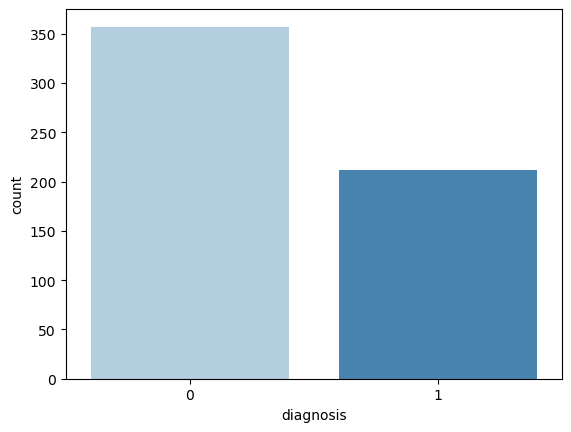

In [4]:
sns.countplot(data = df,x = 'diagnosis', palette='Blues')

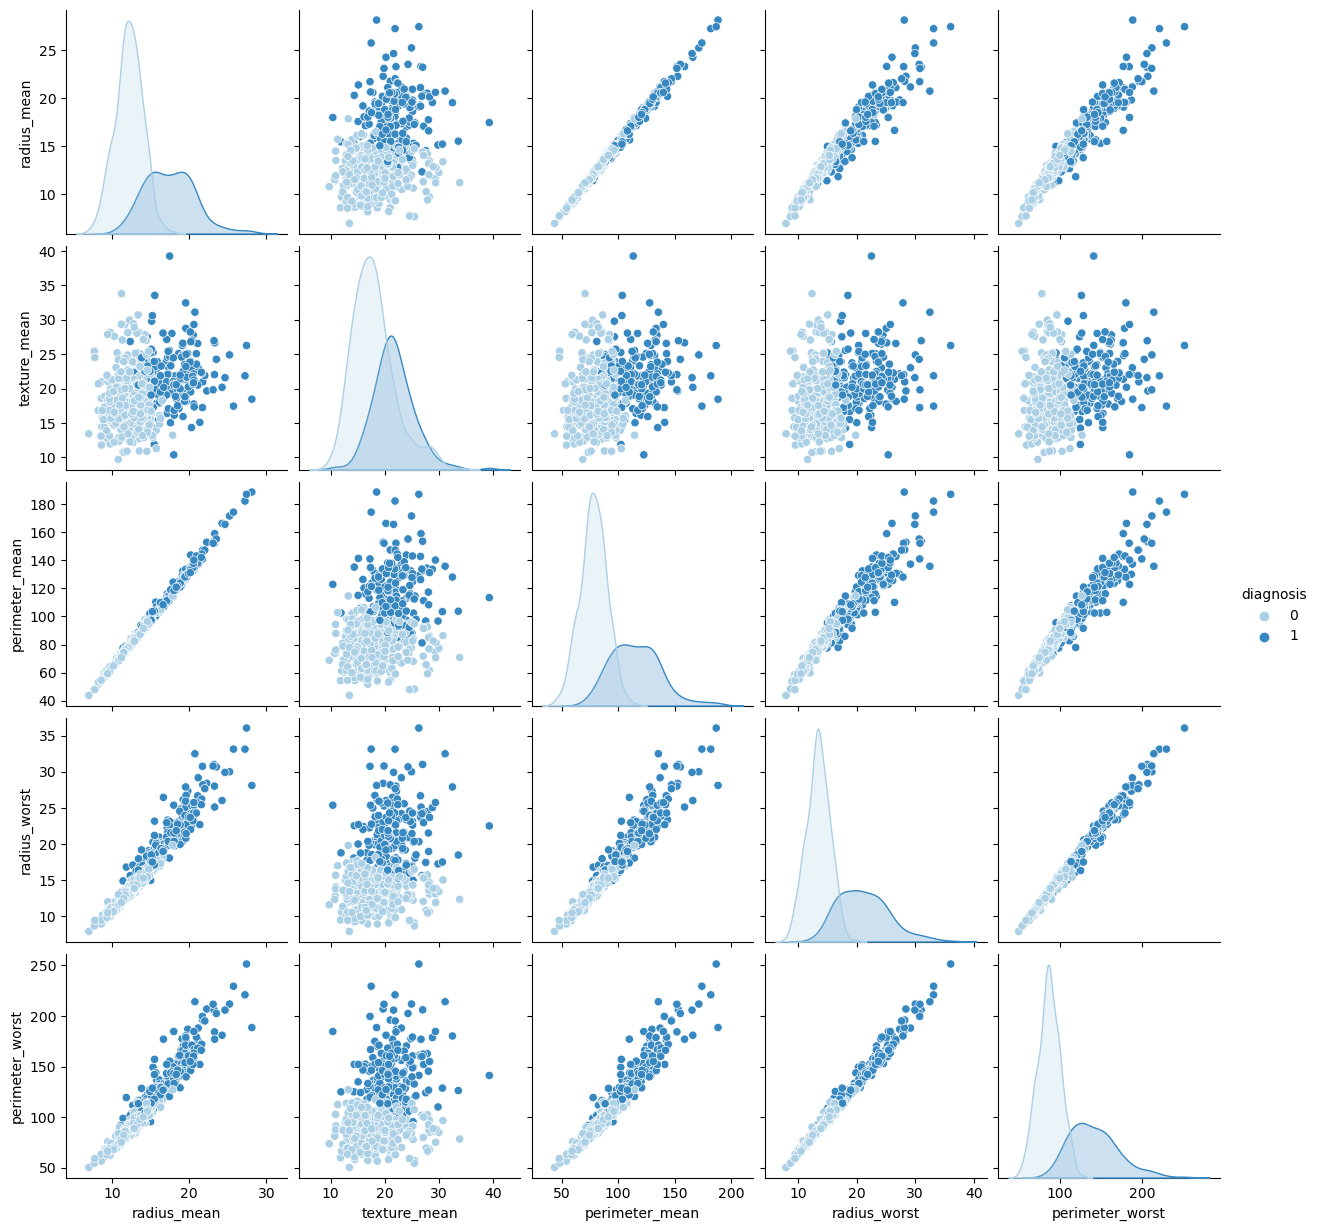

In [5]:
sns.pairplot(df, hue="diagnosis", vars=["radius_mean",
                                        "texture_mean",
                                        "perimeter_mean",
                                        "radius_worst",
                                        "perimeter_worst"], palette='Blues');

Как видно из графиков, рак груди соответствует большим значениям данным. Это объясняется тем, что злокачественное образование при разрастании увеличивает грудь.

In [6]:
X = df.drop(['id', 'diagnosis'], axis=1)
y = df.diagnosis.to_numpy()

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

## Реализация KMeans

In [8]:
from scipy.spatial import distance
from sklearn.metrics.pairwise import euclidean_distances

%matplotlib inline

def random_centroids_selection(X, n, k):
    """Рандомно инициализируем центр кластера"""
    result = []
    for obj_id in np.random.randint(0, n, size=k):
        result.append(X[obj_id, :])
    return result

def eval_weight_evolution(centroid_objects_prev, centroid_objects, k):
    """Вычисляем, как сдвинулись центры за один шаг алгоритма"""
    result = []
    for i in range(k):
        dist = distance.euclidean(
            centroid_objects_prev[i],
            centroid_objects[i]
        )
        result.append(dist)
    return result

def eval_centroids(X, k, cluster_lables):
    """Вычисляем новые центроиды с методом усреднения координат"""
    result = []
    for i in range(k):
        new_centroid = X[cluster_lables==i].mean(axis=0)
        result.append(new_centroid)
    return result

def eval_cluster_lables(X, centroid_objects):
    """Вычисляем метки кластеров"""
    # формируем матрицу (n x k), которая содержит расстояние от каждого объекта до каждого центроида
    cluster_distance = euclidean_distances(X, centroid_objects)
    # находим минимальное расстояние в каждой строчке - это будет кластер объекта
    cluster_lables = cluster_distance.argmin(axis=1)
    return cluster_lables

def k_means(X:np.array, k: int=2, eps: float=0.001, num_iteration: int=20) -> np.array:
    """Алгоритм К-средних
    
    :param X: обучающая выборка
    :param k: количество кластеров
    """
    try:
        n, m = X.shape
    except ValueError:
        print("Обучающая выборка должна быть двумерным массивом (n, m) гдк m - размер выборки")
    # инициализируем центроиды случайным элементом выборки
    centroid_objects = random_centroids_selection(X, n, k)
    centroid_objects_prev = [np.zeros(m) for i in range(k)]
    # расстояние между предыдущим и текущим положением каждого центроида
    weight_evolution = eval_weight_evolution(centroid_objects_prev, centroid_objects, k)
    step = 0
    # условие остановки: центроиды не изменили своего положения
    # повторяем до выполнения условия остановки
    while sum(weight_evolution[i] > eps for i in range(k))!=0 and step < num_iteration:
        # иначе можно прострелить себе ногу =0
        centroid_objects_prev = centroid_objects.copy()
        # вычисляем метки кластеров
        cluster_lables = eval_cluster_lables(X, centroid_objects)
        # усредняем координаты объектов каждого кластера - это новое положение центроида
        centroid_objects = eval_centroids(X, k, cluster_lables)
        # вычисляем расстояние между центроидами на соседних итерациях
        weight_evolution = eval_weight_evolution(centroid_objects_prev, centroid_objects, k)
        # обновлённые кластера
        step += 1
    return np.vstack(centroid_objects), cluster_lables

In [9]:
from sklearn import metrics

In [10]:
%%time
centroids, labels = k_means(X, k=2, num_iteration=20)
metrics.homogeneity_score(y, labels)

Wall time: 24 ms


0.5442739102091959

## KMeans из Sklearn

In [11]:
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

In [12]:
parameters = {'n_clusters': [2, 3, 4],
              'n_init': [3, 5, 10, 20],
              'max_iter':range(10, 101, 10),
              'random_state': [9856]}
km = KMeans()
grid = GridSearchCV(km, parameters, n_jobs=-1, scoring='homogeneity_score')
grid.fit(X, y)
print(grid.best_params_, '\n', grid.best_score_)

{'max_iter': 30, 'n_clusters': 4, 'n_init': 20, 'random_state': 9856} 
 0.6550950460454704


In [13]:
best_kmeans = grid.best_estimator_

In [14]:
def show_metrics(estimator, X, y):
    labels = estimator.fit_predict(X)
    labels_true = y
    print(f"Homogeneity: {metrics.homogeneity_score(labels_true, labels):.3f}")
    print(f"Completeness: {metrics.completeness_score(labels_true, labels):.3f}")
    print(f"V-measure: {metrics.v_measure_score(labels_true, labels):.3f}")
    print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(labels_true, labels):.3f}")
    print("Adjusted Mutual Information:" f" {metrics.adjusted_mutual_info_score(labels_true, labels):.3f}")
    print(f"Silhouette Coefficient: {metrics.silhouette_score(X, labels):.3f}")

In [15]:
show_metrics(best_kmeans, X, y)

Homogeneity: 0.604
Completeness: 0.373
V-measure: 0.461
Adjusted Rand Index: 0.554
Adjusted Mutual Information: 0.460
Silhouette Coefficient: 0.284


In [16]:
%%time
best_kmeans.fit(X)

Wall time: 104 ms


KMeans(max_iter=30, n_clusters=4, n_init=20, random_state=9856)

## Affinity Propagation

In [17]:
from sklearn.cluster import AffinityPropagation

In [18]:
parameters = {'damping': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
              'convergence_iter': range(5, 25, 5)}

ap = AffinityPropagation(random_state=16)
grid = GridSearchCV(ap, parameters, n_jobs=-1, scoring='homogeneity_score')
grid.fit(X,y)
print(grid.best_params_, '\n', grid.best_score_)

{'convergence_iter': 15, 'damping': 0.7} 
 0.8798027407208696


In [19]:
best_affinity = grid.best_estimator_

In [20]:
show_metrics(best_affinity, X, y)

Homogeneity: 0.836
Completeness: 0.159
V-measure: 0.267
Adjusted Rand Index: 0.053
Adjusted Mutual Information: 0.249
Silhouette Coefficient: 0.085


In [21]:
%%time
best_affinity.fit(X)

Wall time: 742 ms


AffinityPropagation(damping=0.7, random_state=16)

## PCA

In [22]:
from sklearn.decomposition import PCA

In [23]:
explained_variance = []
x = []
for i in range(5, X.shape[1], 1):
    pca = PCA(n_components=i)
    pca.fit(X)
    explained_variance.append(sum(pca.explained_variance_ratio_))
    x.append(i)

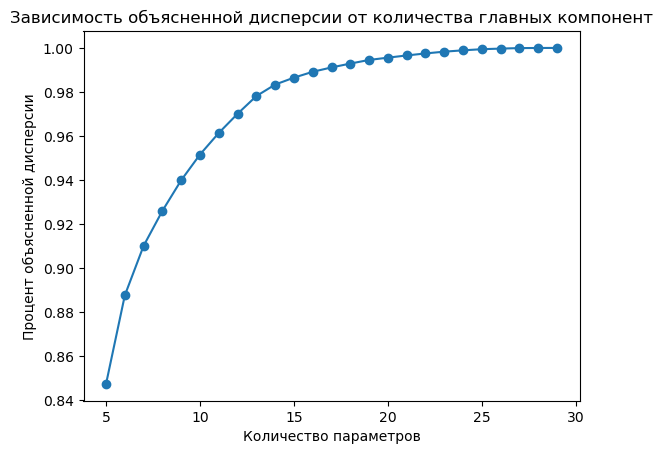

In [24]:
plt.plot(x, explained_variance, marker='o')
plt.title('Зависимость объясненной дисперсии от количества главных компонент')
plt.xlabel('Количество параметров')
plt.ylabel('Процент объясненной дисперсии')
plt.show()

In [25]:
pca = PCA(n_components=7)
pca.fit(X)
sum(pca.explained_variance_ratio_)

0.9100953006942457

In [26]:
pca = PCA(n_components=15)
pca.fit(X)
sum(pca.explained_variance_ratio_)

0.9864881227137592

При сокращение данных до 15 компонент почти вся информация сохраняется. При 7 теряется всего 9% информации.

Сохраним эти 2 значения главных компонент

In [27]:
pca = PCA(n_components=7)
X_7 = pca.fit_transform(X)
pca = PCA(n_components=15)
X_15 = pca.fit_transform(X)

In [28]:
show_metrics(best_kmeans, X, y)

Homogeneity: 0.604
Completeness: 0.373
V-measure: 0.461
Adjusted Rand Index: 0.554
Adjusted Mutual Information: 0.460
Silhouette Coefficient: 0.284


In [29]:
show_metrics(best_kmeans, X_7, y)

Homogeneity: 0.607
Completeness: 0.374
V-measure: 0.463
Adjusted Rand Index: 0.553
Adjusted Mutual Information: 0.461
Silhouette Coefficient: 0.309


In [30]:
show_metrics(best_kmeans, X_15, y)

Homogeneity: 0.602
Completeness: 0.371
V-measure: 0.459
Adjusted Rand Index: 0.550
Adjusted Mutual Information: 0.457
Silhouette Coefficient: 0.287


In [31]:
show_metrics(best_affinity, X, y)

Homogeneity: 0.836
Completeness: 0.159
V-measure: 0.267
Adjusted Rand Index: 0.053
Adjusted Mutual Information: 0.249
Silhouette Coefficient: 0.085


In [32]:
show_metrics(best_affinity, X_7, y)

Homogeneity: 0.832
Completeness: 0.162
V-measure: 0.272
Adjusted Rand Index: 0.060
Adjusted Mutual Information: 0.256
Silhouette Coefficient: 0.130


In [33]:
show_metrics(best_affinity, X_15, y)

Homogeneity: 0.837
Completeness: 0.158
V-measure: 0.266
Adjusted Rand Index: 0.052
Adjusted Mutual Information: 0.248
Silhouette Coefficient: 0.089


При сокращении параметров с 30 до 7 мы уменьшили количество данных более чем в 4 раза, при этом метрики изменились не значительно. 

При ограниченности ресурсов такое сокращение данных является целесообразным.

## Визуализация данных снижением размерности до 2

In [34]:
from sklearn.manifold import TSNE

Wall time: 12 ms


Text(0.5, 1.0, 'Breast Cancer Dataset. PCA projection')

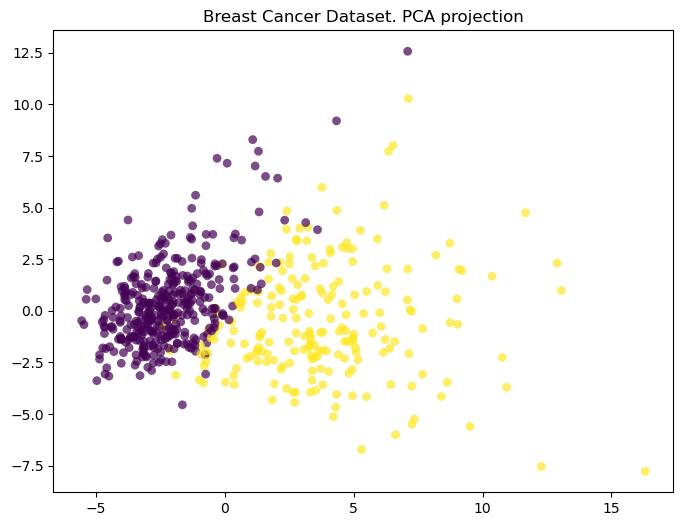

In [35]:
%%time
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)


plt.figure(figsize=(8,6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40)
plt.title('Breast Cancer Dataset. PCA projection');

Wall time: 1.13 s


Text(0.5, 1.0, 'Breast Cancer Dataset. t-SNE projection')

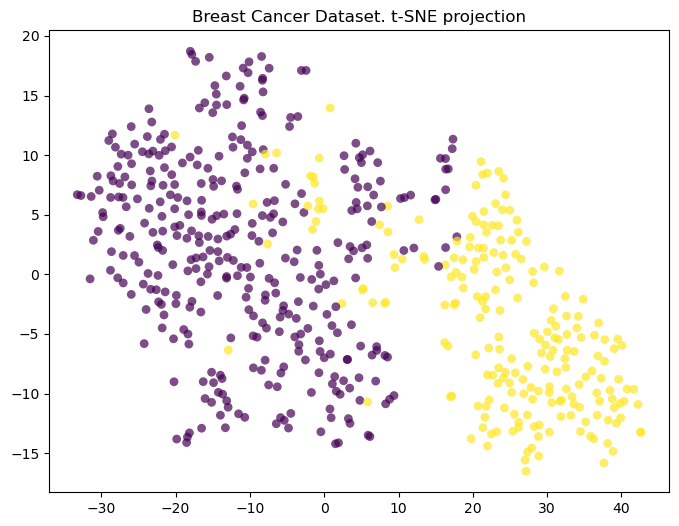

In [36]:
%%time

tsne = TSNE(random_state=12)

X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=y,
    edgecolor="none",
    alpha=0.7,
    s=40)
plt.title("Breast Cancer Dataset. t-SNE projection");